# Background

a specific idea that comes to mind:
What if we cast active learning as a semantic reranking problem? (relevant: Cohere is SOTA in reranking, e.g. above OpenAI and Anthropic)
Specifically, the step where you sample from an acquisition function and choose the next input to run can be cast as:
Consider your entire domain of possible experiments or a very high-recall subset of it in some discretized form, cast as a set of documents (i.e. JSON of inputs and predicted outputs from some forward predictive model)
Rerank the next possible experiments vs a query (e.g., the latest experiment(s) and result(s))
Then benchmark actual performance of:
vanilla reranker
finetuned reranker (e.g., showing positive examples from some classic ML algo, to distill that capability into the semantic reranker)
classic ML algo
The high level loop looks basically the same as the plan here. The advantages are that:
reranking is kind of an unusual way to do this but it is suuuuper cheap cost and latency wise, so if it works then that is a very relevant result. And like LLMs, if it is at least as good as classical, it means it is very generalizable since you don't need to worry about featurization since it's all natural language
finetuning is a strong moat since most people do not know how to do it effectively (and obv here is somewhere I can help with some cohere-informed pro tips)
I can probably find a way to get some cohere credits to cover the cost of production-level inference rate limits
11:20
^^^ 
@Hongchen Wang
 wdyt of this? It is probably doable ~immediately on your membrane project if there aren't any blockers
11:21
(it's basically the same as the plan for using o1, but trying something a bit unusual via trying a reranking setup vs a pure generative setup, which means the input space of candidate next-experiments must be discretized, but that's fine since we were planning that anyway)

finetuning is basically like:
given many sets of {query, document, correct_score}
train the model to predict the correct score
12:32
Although the reranking is generally trained to do stuff like question-answering, like if you query "what is the capital of US" over all of wikipedia, you should get the pages for DC and related pages





12:32
but by manipulating the pairings and the correct score, you can finetune the reranker to emit scores based on whatever you like, while retaining it's underlying semantic reasoning that has been pretrained into it
12:34
so there is probably a cool setup where we do something like:
convert experiment params and results into a markdown "report" (could use any LLM for this)
Summarize the experiments tried so far into a summary of findings plus a question, like "ok so these reagents didn't do so well and I think I should vary X next... what next experiment should I try?"
Then you rerank over the candidate possible markdown docs (which are experiments you could run, perhaps also with their predicted results generated via an LLM in markdown)
12:35
it's kinda of a crazy reframe of active learning into "what if everything is a short wiki style markdown document, and we are actually just doing ranking over real empirical documents and hypothetical future documents"
12:35
and the finetune data can just come from your past experiments where you know the results, translated into these markdown docs

# Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# Load datasets

In [2]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [3]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26.csv')
df_parameters

,Auto,Heating,Concentration,Batch,Sample,Mixing Height and Lift Adjusted,Heated Container,Heated Block,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,10.00,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,True,False,11.63,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
2,True,False,14.43,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.011184
3,True,False,17.00,3,1,1,0,0,25,False,4,0.0,1,0,2024-02-12,64,0,0,0.013384
4,True,False,10.00,4,1,1,0,0,25,True,1,0.0,1,0,2024-02-23,61,0,0,0.156273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,False,False,15.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041
75,False,False,17.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.139232
76,True,True,15.00,36,1,1,0,1,80,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
77,True,True,17.00,36,1,1,0,1,80,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [4]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
data = data[data['Fit'] == True]
# heating
# data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
# data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
#data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
5,Auto_noheating_12wt_3_1_2,True,False,11.63,3,1,2,110.0000,99.227054,10.405136,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Auto_heating_15_36_1_1,True,True,15.00,36,1,1,110.6170,94.924662,9.078378,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
237,Auto_heating_15_36_1_2,True,True,15.00,36,1,2,115.5446,109.038526,10.173041,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [5]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,15.00,32,1,179.780045,12.059961,42.843561,34.215705,0.025644,...,False,0,0.0,1,1,2024-11-14,46,0,0,0.248858
1,True,False,10.00,13,1,106.819343,NaN,14.184020,NaN,NaN,...,True,1,0.0,1,1,2024-07-24,80,1,0,0.164578
2,False,False,12.00,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,False,0,0.0,1,1,2024-11-13,48,0,0,0.169626
3,False,False,17.00,16,2,255.042207,NaN,17.730913,NaN,0.044643,...,False,0,0.0,1,1,2024-08-30,87,0,0,0.033307
4,True,False,17.00,18,2,171.004694,6.907569,13.029225,0.590966,0.039766,...,False,0,0.0,1,1,2024-09-09,82,0,0,0.017871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,True,False,15.00,34,1,140.768713,24.681104,16.902020,9.655240,0.026833,...,True,1,0.0,1,1,2024-11-15,50,0,0,0.137876
63,True,False,10.00,32,1,50.104314,NaN,10.983408,NaN,0.012758,...,False,0,0.0,1,1,2024-11-14,46,0,0,0.000000
64,True,True,11.63,7,2,90.998710,9.505165,34.615127,17.245104,NaN,...,True,0,0.0,1,0,2024-03-20,69,0,0,0.236195
65,True,False,10.00,6,3,69.026405,8.279371,5.943005,1.921989,NaN,...,True,3,0.0,1,0,2024-03-01,55,0,0,0.262396


# Random

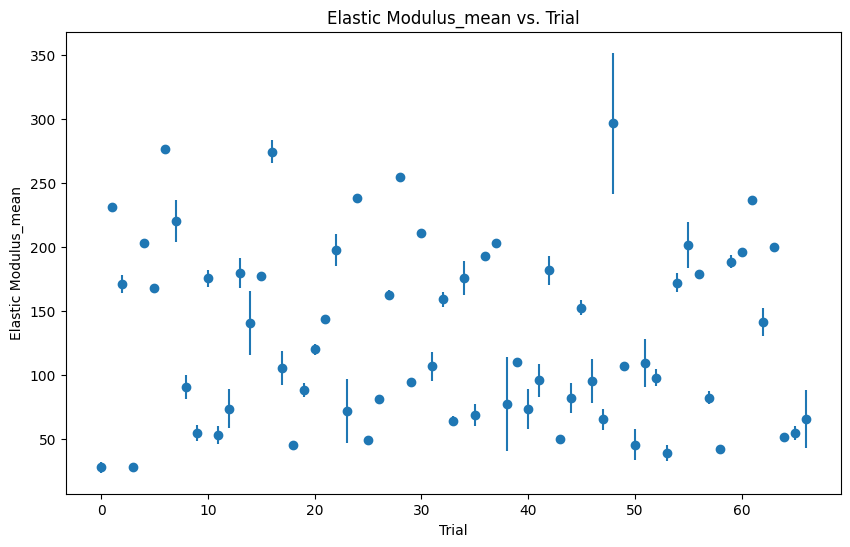

In [6]:
# shuffle the data 
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
# plot Elastic Modulus_mean vs. a time axis, also add the error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data_grouped.index, data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.xlabel('Trial')
plt.ylabel('Elastic Modulus_mean')
plt.title('Elastic Modulus_mean vs. Trial')
plt.show()


# Traditional ML

In [13]:
# Preprocessing 
X = data_grouped.drop([
    'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
    'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
    'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
    'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date', 
    'Average Standard Deviation_mean', 'Average Standard Deviation_std',
    'Coefficient of Variation_mean', 'Coefficient of Variation_std',
    'Coefficient of Variation', 'Batch'
], axis=1)
y = data_grouped['Elastic Modulus_mean']
yerr = data_grouped['Elastic Modulus_std']

# Normalize input features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Initial training data
X_train = X.sample(10, random_state=42)
y_train = y[X_train.index]
yerr_train = yerr[X_train.index]
X_train_normalized = scaler.transform(X_train)


In [8]:
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        """
        Initialize the active learning setup.

        Parameters:
        - kernel: The kernel for the Gaussian Process (default is RBF).
        - alpha: Exploration-exploitation tradeoff parameter.
        """
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)
        self.X_train = None
        self.y_train = None

    def update_model(self, X_train, y_train):
        """
        Update the regression model with new training data.
        
        Parameters:
        - X_train: Training input data.
        - y_train: Training target data.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        """
        Compute the UCB acquisition scores for candidate points.

        Parameters:
        - X_candidates: Candidate input data points.

        Returns:
        - UCB scores for all candidate points.
        """
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std

    def select_next_point(self, X_candidates):
        """
        Select the next query point based on the UCB criterion.

        Parameters:
        - X_candidates: Candidate input data points.

        Returns:
        - The index of the selected candidate point.
        """
        ucb_scores = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores


d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.

Iteration 1: Selected index 34, Alpha: 3.00, MSE: 3757.075937
Iteration 2: Selected index 37, Alpha: 2.73, MSE: 5184.781601
Iteration 3: Selected index 16, Alpha: 2.50, MSE: 5185.159928
Iteration 4: Selected index 6, Alpha: 2.31, MSE: 9014.125785
Iteration 5: Selected index 61, Alpha: 2.14, MSE: 9019.286002


d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-p

Iteration 6: Selected index 10, Alpha: 2.00, MSE: 9013.341207
Iteration 7: Selected index 13, Alpha: 1.88, MSE: 9979.136990
Iteration 8: Selected index 4, Alpha: 1.76, MSE: 9979.127348
Iteration 9: Selected index 7, Alpha: 1.67, MSE: 9524.157918


d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-p

Iteration 10: Selected index 36, Alpha: 1.58, MSE: 9517.601250
Iteration 11: Selected index 55, Alpha: 1.50, MSE: 10313.909247
Iteration 12: Selected index 5, Alpha: 1.43, MSE: 10314.268761
Iteration 13: Selected index 45, Alpha: 1.36, MSE: 10313.888730


d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-p

Iteration 14: Selected index 46, Alpha: 1.30, MSE: 10514.585824
Iteration 15: Selected index 39, Alpha: 1.25, MSE: 10502.633209
Iteration 16: Selected index 21, Alpha: 1.20, MSE: 11808.308252
Iteration 17: Selected index 43, Alpha: 1.15, MSE: 12413.283213


d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", 

Iteration 18: Selected index 66, Alpha: 1.11, MSE: 12424.328942
Iteration 19: Selected index 59, Alpha: 1.07, MSE: 12109.034427
Iteration 20: Selected index 12, Alpha: 1.03, MSE: 12109.017628


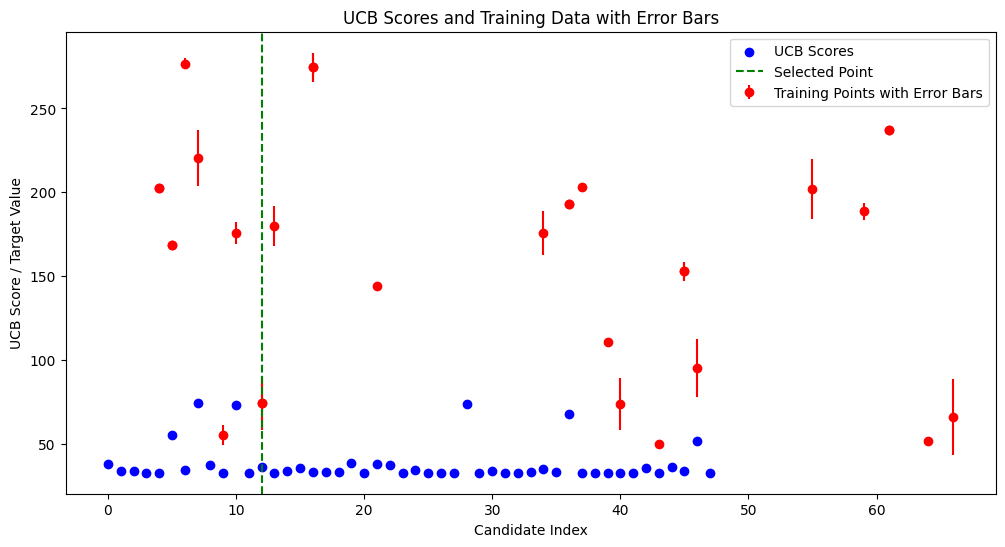

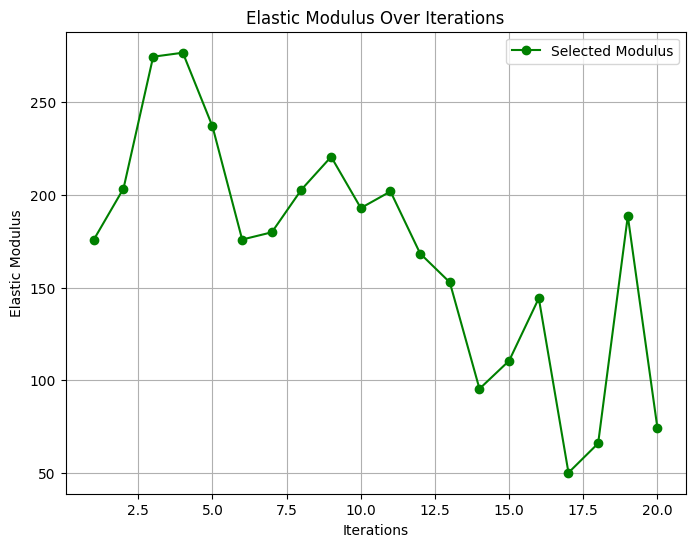

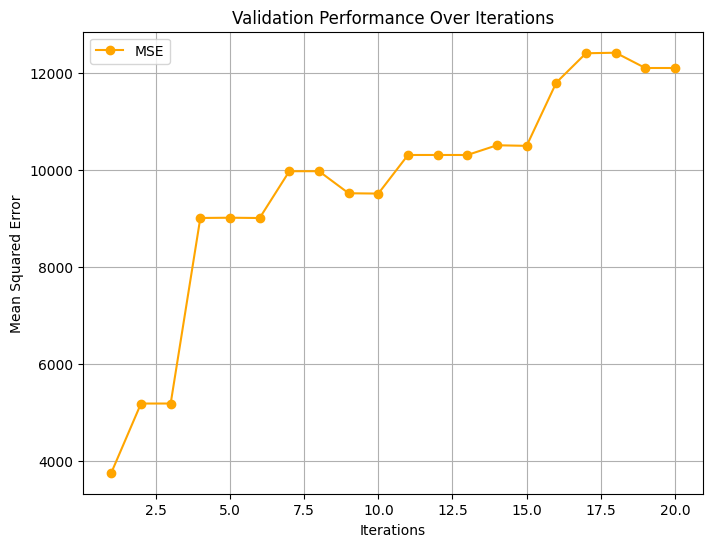

In [9]:
# Initialize the active learning model
al_model = ActiveLearningUCB()
al_model.update_model(X_train_normalized, y_train.values)

# Active learning loop parameters
max_iterations = 20  # Maximum number of iterations
X_candidates = X_normalized  # All normalized data
selected_indices = []  # To track selected points
iteration_indices = []  # To store iteration numbers
selected_modulus = []  # Store the Elastic Modulus of the selected points
mse_per_iteration = []  # Store MSE values for validation
early_stopping_threshold = 1e-4  # Threshold for early stopping

# Validation set
X_validation = scaler.transform(X)  # Replace with a proper validation set if available
y_validation = y.values  # Replace with validation targets

for iteration in range(max_iterations):
    # Dynamic Alpha Adjustment
    al_model.alpha = max(1, 3 / (1 + iteration * 0.1))  # Exponential decay of alpha

    # Filter candidates to exclude already selected points
    available_indices = [i for i in range(len(X_candidates)) if i not in selected_indices]
    X_candidates_filtered = X_candidates[available_indices]

    # Select the next point based on UCB
    selected_idx_local, ucb_scores = al_model.select_next_point(X_candidates_filtered)
    selected_idx = available_indices[selected_idx_local]  # Map back to original indices

    # Save iteration index and selected modulus
    iteration_indices.append(iteration + 1)
    selected_indices.append(selected_idx)
    selected_modulus.append(y.iloc[selected_idx])

    # Add selected point to the training set
    X_new = X.iloc[[selected_idx]]
    y_new = y.iloc[[selected_idx]]
    yerr_new = yerr.iloc[[selected_idx]]

    X_new_normalized = scaler.transform(X_new)
    X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

    X_train = pd.concat([X_train, X_new])
    y_train = pd.concat([y_train, y_new])
    yerr_train = pd.concat([yerr_train, yerr_new])

    # Update the model with the new training set
    al_model.update_model(X_train_normalized, y_train.values)

    # Performance Validation: Calculate MSE on validation data
    predictions = al_model.model.predict(X_validation)
    mse = mean_squared_error(y_validation, predictions)
    mse_per_iteration.append(mse)

    print(f"Iteration {iteration + 1}: Selected index {selected_idx}, Alpha: {al_model.alpha:.2f}, MSE: {mse:.6f}")

    # Early Stopping Criterion
    if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
        print(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
        break

# Plot UCB Scores and Training Data with Error Bars
plt.figure(figsize=(12, 6))
plt.errorbar(X_train.index, y_train, yerr=yerr_train, fmt='o', color='red', label="Training Points with Error Bars")
plt.scatter(range(len(ucb_scores)), ucb_scores, label="UCB Scores", color="blue")
plt.axvline(x=selected_idx, color="green", linestyle="--", label="Selected Point")
plt.xlabel("Candidate Index")
plt.ylabel("UCB Score / Target Value")
plt.title("UCB Scores and Training Data with Error Bars")
plt.legend()
plt.show()

# Plot Modulus vs. Iterations
plt.figure(figsize=(8, 6))
plt.plot(iteration_indices, selected_modulus, marker='o', label="Selected Modulus", color="green")
plt.xlabel("Iterations")
plt.ylabel("Elastic Modulus")
plt.title("Elastic Modulus Over Iterations")
plt.legend()
plt.grid()
plt.show()

# Plot MSE vs. Iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker='o', label="MSE", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Validation Performance Over Iterations")
plt.legend()
plt.grid()
plt.show()


# Modularized Code

d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:40,683 - INFO - Iteration 1: Alpha=1.00
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:40,719 - INFO - Iteration 1: Selected Index=16, MSE=4280.325448
2025-02-12 16:10:40,719 - INFO - Iteration 2: Alpha=0.91
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to th

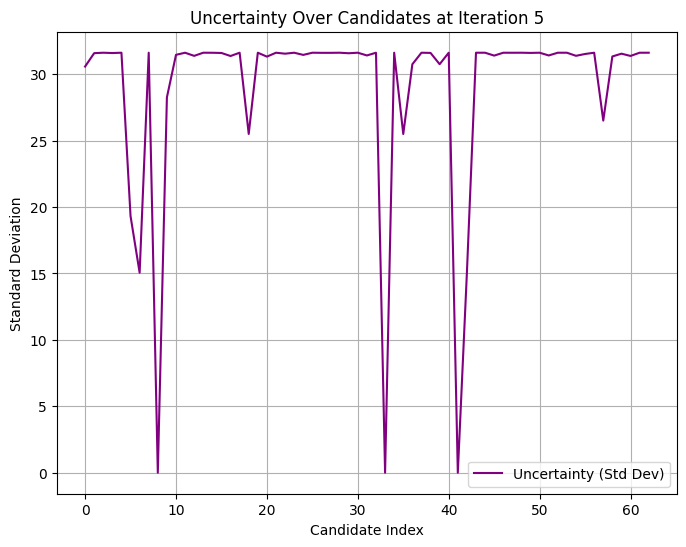

2025-02-12 16:10:40,903 - INFO - Iteration 6: Alpha=0.67
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:40,944 - INFO - Iteration 6: Selected Index=6, MSE=14371.124108
2025-02-12 16:10:40,944 - INFO - Iteration 7: Alpha=0.62
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:40,987 - INFO - Iteration 7: Selected Index=61, MSE=13509.934484
2025-02-12 16:10:40,987 - INFO - Iteration 8: Alpha=0.59
d:\Anaconda\envs\py37\lib\site-packages\sklearn\

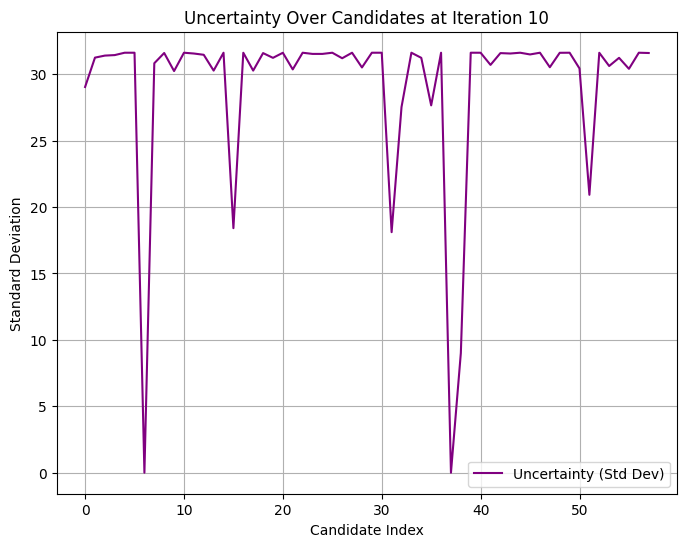

2025-02-12 16:10:41,198 - INFO - Iteration 11: Alpha=0.50
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:41,236 - INFO - Iteration 11: Selected Index=46, MSE=12536.404958
2025-02-12 16:10:41,236 - INFO - Iteration 12: Alpha=0.48
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 o

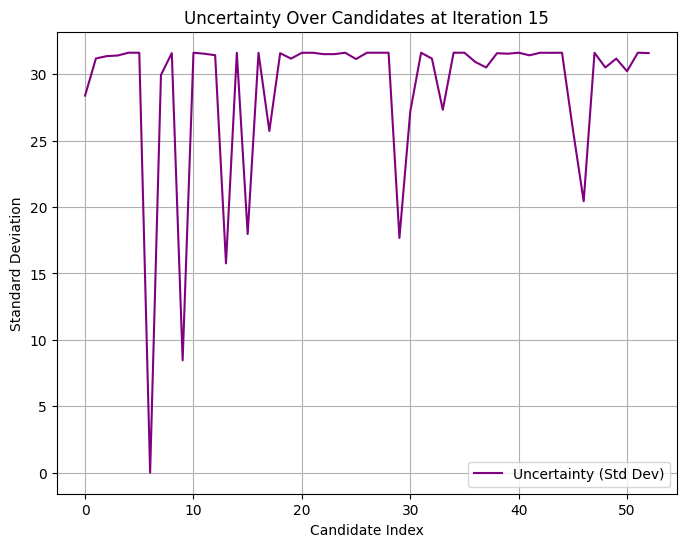

2025-02-12 16:10:41,678 - INFO - Iteration 16: Alpha=0.40
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:41,720 - INFO - Iteration 16: Selected Index=19, MSE=12165.520024
2025-02-12 16:10:41,720 - INFO - Iteration 17: Alpha=0.38
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 o

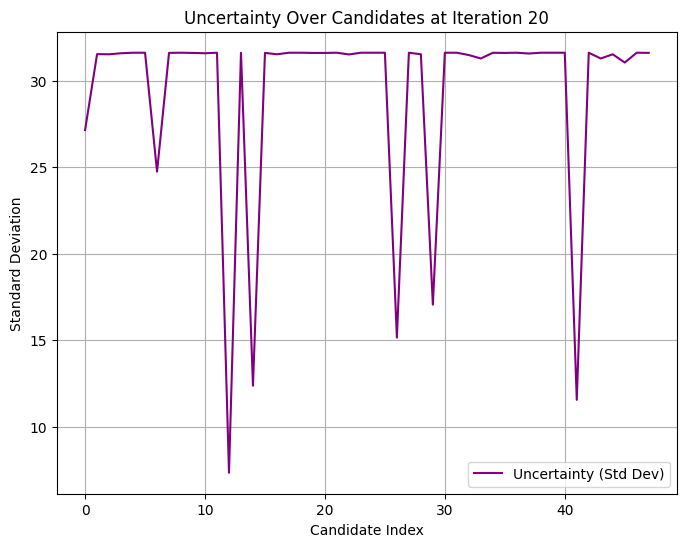

2025-02-12 16:10:41,957 - INFO - Iteration 21: Alpha=0.33
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:41,997 - INFO - Iteration 21: Selected Index=43, MSE=12195.330789
2025-02-12 16:10:41,997 - INFO - Iteration 22: Alpha=0.32
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMA

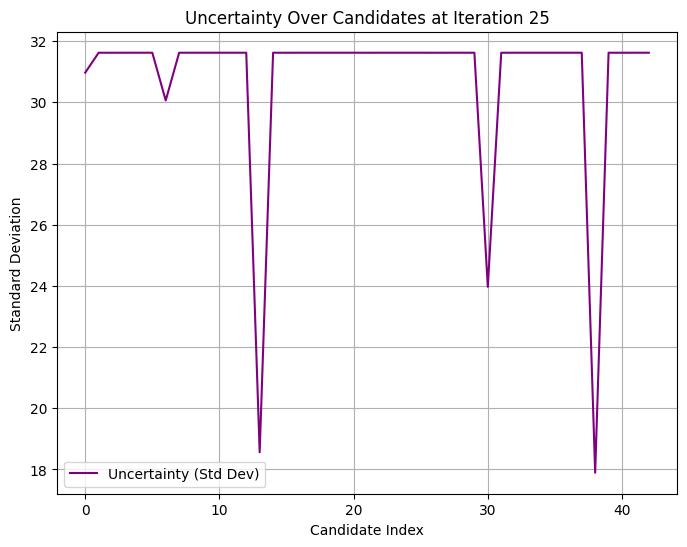

2025-02-12 16:10:42,290 - INFO - Iteration 26: Alpha=0.29
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
2025-02-12 16:10:42,343 - INFO - Iteration 26: Selected Index=32, MSE=11389.057488
2025-02-12 16:10:42,343 - INFO - Iteration 27: Alpha=0.28
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 o

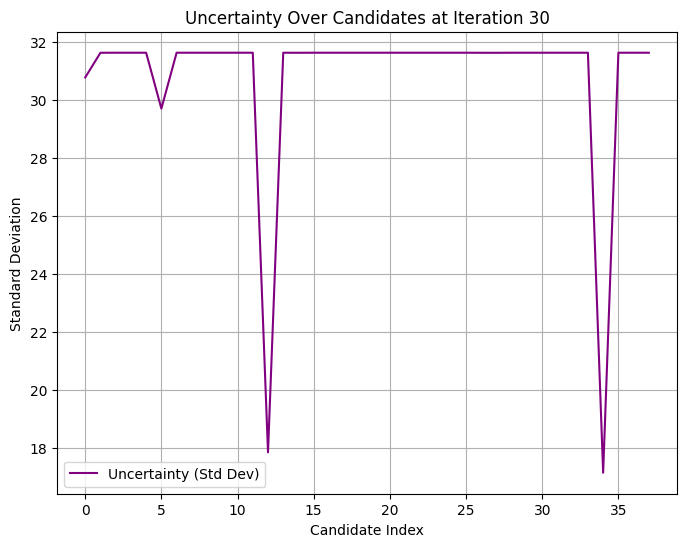

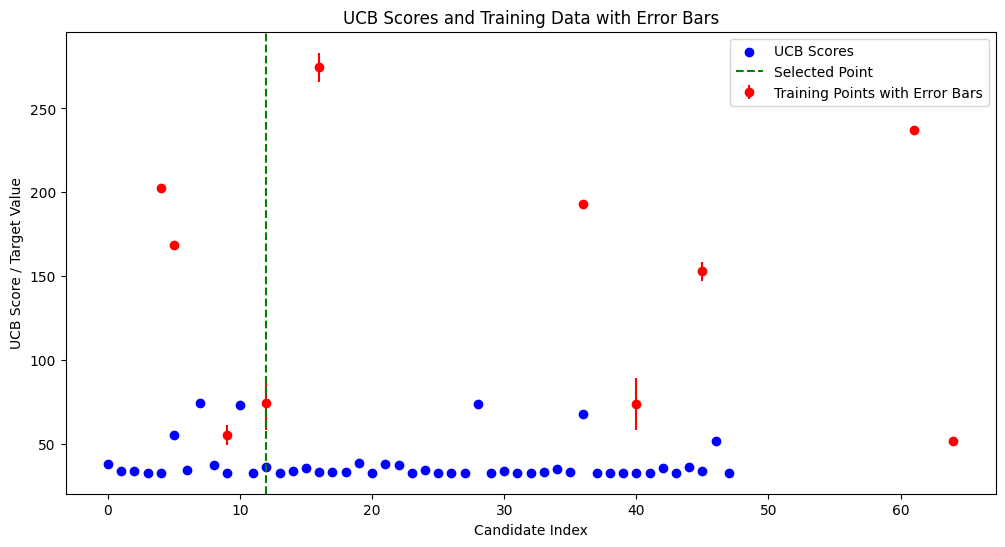

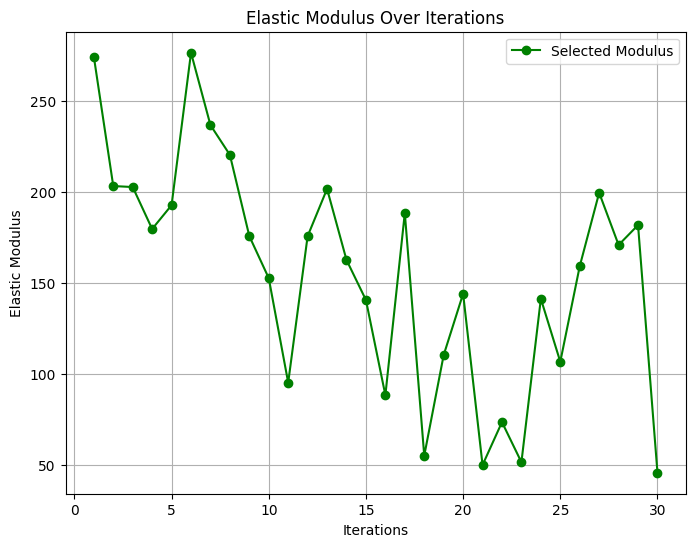

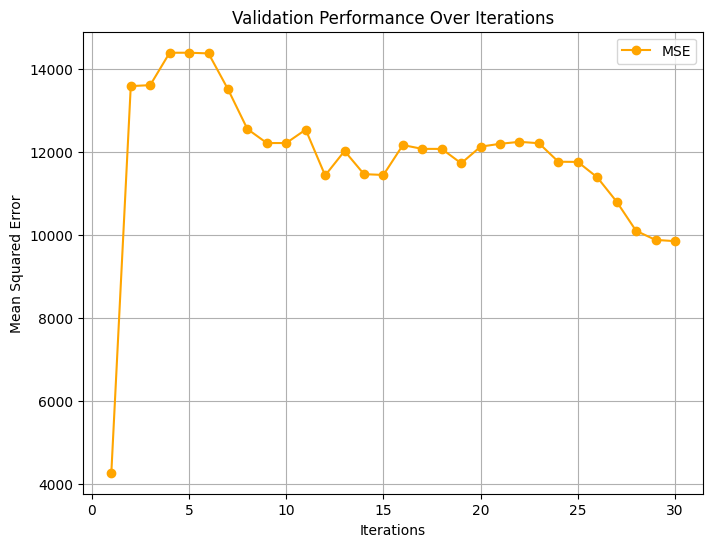

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


# Preprocessing
def preprocess_data(data):
    X = data.drop([
        'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
        'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
        'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
        'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
        'Average Standard Deviation_mean', 'Average Standard Deviation_std',
        'Coefficient of Variation_mean', 'Coefficient of Variation_std',
        'Coefficient of Variation', 'Batch'
    ], axis=1)
    y = data['Elastic Modulus_mean']
    yerr = data['Elastic Modulus_std']
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X, y, yerr, X_normalized, scaler


# Active Learning Loop
def run_active_learning(data, initial_train_point = 10, max_iterations=20, alpha_initial=3, alpha_decay=0.1, early_stopping_threshold=1e-4):
    # Preprocess data
    X, y, yerr, X_normalized, scaler = preprocess_data(data)

    # Initial training data
    X_train = X.sample(initial_train_point, random_state=42)
    y_train = y[X_train.index]
    yerr_train = yerr[X_train.index]
    X_train_normalized = scaler.transform(X_train)

    # Initialize Active Learning Model
    al_model = ActiveLearningUCB(alpha=alpha_initial)
    al_model.update_model(X_train_normalized, y_train.values)

    # Initialize tracking variables
    selected_indices = []
    iteration_indices = []
    selected_modulus = []
    mse_per_iteration = []
    prev_std_mean = None  # To track uncertainty reduction

    for iteration in range(max_iterations):
        # Dynamic Alpha Adjustment
        al_model.alpha = max(0.1, alpha_initial / (1 + iteration * alpha_decay))
        logging.info(f"Iteration {iteration + 1}: Alpha={al_model.alpha:.2f}")

        # Filter candidates to exclude already selected points
        available_indices = [i for i in range(len(X_normalized)) if i not in selected_indices] # no duplicate selection
        #available_indices = [i for i in range(len(X_normalized))] # duplicate selection
        X_candidates_filtered = X_normalized[available_indices]

        # Select the next point
        selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
        selected_idx = available_indices[selected_idx_local]

        # Save selected point information
        iteration_indices.append(iteration + 1)
        selected_indices.append(selected_idx)
        selected_modulus.append(y.iloc[selected_idx])

        # Update training data
        X_new = X.iloc[[selected_idx]]
        y_new = y.iloc[[selected_idx]]
        yerr_new = yerr.iloc[[selected_idx]]

        X_new_normalized = scaler.transform(X_new)
        X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

        X_train = pd.concat([X_train, X_new])
        y_train = pd.concat([y_train, y_new])
        yerr_train = pd.concat([yerr_train, yerr_new])

        al_model.update_model(X_train_normalized, y_train.values)

        # Performance Validation
        predictions = al_model.model.predict(X_normalized)
        mse = mean_squared_error(y, predictions)
        mse_per_iteration.append(mse)
        logging.info(f"Iteration {iteration + 1}: Selected Index={selected_idx}, MSE={mse:.6f}")

        # Check Early Stopping Criterion
        if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
            logging.info(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
            break

        # Uncertainty Visualization (optional per iteration)
        if iteration == max_iterations - 1 or (iteration + 1) % 5 == 0:  # Plot every 5 iterations
            plt.figure(figsize=(8, 6))
            plt.plot(range(len(std)), std, label="Uncertainty (Std Dev)", color="purple")
            plt.xlabel("Candidate Index")
            plt.ylabel("Standard Deviation")
            plt.title(f"Uncertainty Over Candidates at Iteration {iteration + 1}")
            plt.legend()
            plt.grid()
            plt.show()

    # Final Visualizations
    plot_results(iteration_indices, selected_modulus, mse_per_iteration)


# Plot Results
def plot_results(iteration_indices, selected_modulus, mse_per_iteration):
    # Plot UCB Scores and Training Data with Error Bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(X_train.index, y_train, yerr=yerr_train, fmt='o', color='red', label="Training Points with Error Bars")
    plt.scatter(range(len(ucb_scores)), ucb_scores, label="UCB Scores", color="blue")
    plt.axvline(x=selected_idx, color="green", linestyle="--", label="Selected Point")
    plt.xlabel("Candidate Index")
    plt.ylabel("UCB Score / Target Value")
    plt.title("UCB Scores and Training Data with Error Bars")
    plt.legend()
    plt.show()
    # Plot Modulus vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(iteration_indices, selected_modulus, marker='o', label="Selected Modulus", color="green")
    plt.xlabel("Iterations")
    plt.ylabel("Elastic Modulus")
    plt.title("Elastic Modulus Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot MSE vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker='o', label="MSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Validation Performance Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()


run_active_learning(data_grouped, initial_train_point=5, max_iterations=30, alpha_initial=1, alpha_decay=0.1, early_stopping_threshold=1e-4)


# Data Generation

In [30]:
import numpy as np
import pandas as pd
import logging
import json
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


# Preprocessing
def preprocess_data(data):
    X = data.drop([
        'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
        'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
        'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
        'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
        'Average Standard Deviation_mean', 'Average Standard Deviation_std',
        'Coefficient of Variation_mean', 'Coefficient of Variation_std',
        'Coefficient of Variation', 'Batch'
    ], axis=1)
    y = data['Elastic Modulus_mean']
    yerr = data['Elastic Modulus_std']
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X, y, yerr, X_normalized, scaler

# Generate LLM Fine-Tuning Dataset with Uncertainty
def generate_al_dataset(data, initial_train_sizes=[5, 10, 15], max_iterations=10, alpha_initial=1, alpha_decay=0.1):
    X, y, yerr, X_normalized, scaler = preprocess_data(data)
    dataset = []
    
    for initial_train_point in initial_train_sizes:
        logging.info(f"Generating dataset for initial training size: {initial_train_point}")
        
        X_train = X.sample(initial_train_point, random_state=42)
        y_train = y[X_train.index]
        X_train_normalized = scaler.transform(X_train)
        
        al_model = ActiveLearningUCB(alpha=alpha_initial)
        
        # Check for NaN or Inf values in X_train_normalized and y_train before training
        if np.isnan(X_train_normalized).any() or np.isinf(X_train_normalized).any():
            logging.warning("NaN or Inf values detected in X_train_normalized. Replacing them.")
            X_train_normalized = np.nan_to_num(X_train_normalized, nan=np.nanmean(X_train_normalized))
        
        if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
            logging.warning("NaN or Inf values detected in y_train. Replacing them.")
            y_train = y_train.fillna(y_train.mean())
        
        al_model.update_model(X_train_normalized, y_train.values)
        
        selected_indices = set(X_train.index)
        
        for iteration in range(max_iterations):
            al_model.alpha = max(0.1, alpha_initial / (1 + iteration * alpha_decay))
            
            available_indices = [i for i in range(len(X)) if i not in selected_indices]
            if not available_indices:
                break
            
            X_candidates_filtered = X_normalized[available_indices]
            selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
            selected_idx = available_indices[selected_idx_local]
            
            X_new = X.iloc[selected_idx].values
            y_new = y.iloc[selected_idx]
            
            dataset.append({
                "iteration": iteration + 1,
                "initial_train_size": initial_train_point,
                "input": X_train.values.tolist(),
                "output": X_new.tolist(),
                "uncertainty": {
                    "mean_prediction": mean[selected_idx_local],
                    "std_dev": std[selected_idx_local]
                }
            })
            
            selected_indices.add(selected_idx)
            
            X_train = pd.concat([X_train, X.iloc[[selected_idx]]])
            y_train = pd.concat([y_train, y.iloc[[selected_idx]]])
            X_train_normalized = scaler.transform(X_train)
            
            # Check again for NaN or Inf values after updates
            if np.isnan(X_train_normalized).any() or np.isinf(X_train_normalized).any():
                logging.warning("NaN or Inf values detected in X_train_normalized after update. Replacing them.")
                X_train_normalized = np.nan_to_num(X_train_normalized, nan=np.nanmean(X_train_normalized))
            
            if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
                logging.warning("NaN or Inf values detected in y_train after update. Replacing them.")
                y_train = y_train.fillna(y_train.mean())
            
            al_model.update_model(X_train_normalized, y_train.values)
    
    return dataset

# Example usage
data_for_llm = generate_al_dataset(data_grouped)

# Convert NumPy types to Python native types
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy arrays to lists
    elif isinstance(obj, np.generic):  
        return obj.item()  # Convert NumPy scalars (int, float, bool) to Python types
    elif isinstance(obj, set):
        return list(obj)  # Convert sets to lists
    return obj

# Save to JSON format for fine-tuning
with open("active_learning_finetuning_data.json", "w") as f:
    json.dump(data_for_llm, f, indent=4, default=convert_numpy_types)


2025-02-12 16:34:51,802 - INFO - Generating dataset for initial training size: 5
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
d:\Anaconda\envs\py37\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceW

In [ ]:
import numpy as np
import pandas as pd
import logging
import json
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


# Preprocessing
def preprocess_data(data):
    X = data.drop([
        'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
        'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
        'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
        'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
        'Average Standard Deviation_mean', 'Average Standard Deviation_std',
        'Coefficient of Variation_mean', 'Coefficient of Variation_std',
        'Coefficient of Variation', 'Batch'
    ], axis=1)
    y = data['Elastic Modulus_mean']
    yerr = data['Elastic Modulus_std']
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X, y, yerr, X_normalized, scaler

# Generate LLM Fine-Tuning Dataset in Rerank Format
def generate_rerank_dataset(data, initial_train_sizes=[5, 10, 15], max_iterations=10, alpha_initial=1, alpha_decay=0.1):
    X, y, yerr, X_normalized, scaler = preprocess_data(data)
    dataset = []
    
    for initial_train_point in initial_train_sizes:
        logging.info(f"Generating dataset for initial training size: {initial_train_point}")
        
        X_train = X.sample(initial_train_point, random_state=42)
        y_train = y[X_train.index]
        X_train_normalized = scaler.transform(X_train)
        
        al_model = ActiveLearningUCB(alpha=alpha_initial)
        
        if np.isnan(X_train_normalized).any() or np.isinf(X_train_normalized).any():
            logging.warning("NaN or Inf values detected in X_train_normalized. Replacing them.")
            X_train_normalized = np.nan_to_num(X_train_normalized, nan=np.nanmean(X_train_normalized))
        
        if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
            logging.warning("NaN or Inf values detected in y_train. Replacing them.")
            y_train = y_train.fillna(y_train.mean())
        
        al_model.update_model(X_train_normalized, y_train.values)
        
        selected_indices = set(X_train.index)
        
        for iteration in range(max_iterations):
            al_model.alpha = max(0.1, alpha_initial / (1 + iteration * alpha_decay))
            
            available_indices = [i for i in range(len(X)) if i not in selected_indices]
            if not available_indices:
                break
            
            X_candidates_filtered = X_normalized[available_indices]
            selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
            selected_idx = available_indices[selected_idx_local]
            
            X_new = X.iloc[selected_idx].values
            y_new = y.iloc[selected_idx]
            
            hard_negatives = np.random.choice(X.index.difference([selected_idx]), size=min(5, len(X) - 1), replace=False).tolist()
            
            dataset.append({
                "query": f"Material property prediction for sample {selected_idx}",
                "relevant_passages": [f"Predicted modulus: {y_new}",],
                "hard_negatives": [f"Predicted modulus: {y[i]}" for i in hard_negatives]
            })
            
            selected_indices.add(selected_idx)
            
            X_train = pd.concat([X_train, X.iloc[[selected_idx]]])
            y_train = pd.concat([y_train, y.iloc[[selected_idx]]])
            X_train_normalized = scaler.transform(X_train)
            
            if np.isnan(X_train_normalized).any() or np.isinf(X_train_normalized).any():
                logging.warning("NaN or Inf values detected in X_train_normalized after update. Replacing them.")
                X_train_normalized = np.nan_to_num(X_train_normalized, nan=np.nanmean(X_train_normalized))
            
            if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
                logging.warning("NaN or Inf values detected in y_train after update. Replacing them.")
                y_train = y_train.fillna(y_train.mean())
            
            al_model.update_model(X_train_normalized, y_train.values)
    
    return dataset

# Example usage
data_for_llm = generate_rerank_dataset(data_grouped, initial_train_sizes=[5, 10, 15], max_iterations=10, alpha_initial=1, alpha_decay=0.1)

# Convert NumPy types to Python native types
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy arrays to lists
    elif isinstance(obj, np.generic):  
        return obj.item()  # Convert NumPy scalars (int, float, bool) to Python types
    elif isinstance(obj, set):
        return list(obj)  # Convert sets to lists
    return obj

# Save to JSON format for fine-tuning
with open("active_learning_finetuning_data.json", "w") as f:
    json.dump(data_for_llm, f, indent=4, default=convert_numpy_types)


In [31]:
import pprint
pprint.pprint(data_for_llm[:5])  # Print first few entries to inspect structure


[{'initial_train_size': 5,
  'input': [[True, False, 14.0, 1, 1, 0, 0, 25, True, 1, 0.0, 1, 1, 54, 1, 0],
            [True, False, 17.0, 1, 1, 0, 0, 25, False, 0, 10.0, 1, 1, 58, 0, 1],
            [True, False, 15.0, 1, 1, 0, 0, 25, False, 0, 0.0, 1, 1, 50, 0, 0],
            [True, False, 12.0, 1, 1, 0, 0, 25, True, 0, 0.0, 1, 1, 74, 0, 0],
            [True, False, 12.0, 1, 1, 0, 0, 25, True, 1, 0.0, 1, 1, 54, 1, 0]],
  'iteration': 1,
  'output': [True, False, 17.0, 1, 1, 0, 0, 25, False, 0, 10.0, 1, 1, 68, 0, 1],
  'uncertainty': {'mean_prediction': 261.2325112930636,
                  'std_dev': 8.38582963722307}},
 {'initial_train_size': 5,
  'input': [[True, False, 14.0, 1, 1, 0, 0, 25, True, 1, 0.0, 1, 1, 54, 1, 0],
            [True, False, 17.0, 1, 1, 0, 0, 25, False, 0, 10.0, 1, 1, 58, 0, 1],
            [True, False, 15.0, 1, 1, 0, 0, 25, False, 0, 0.0, 1, 1, 50, 0, 0],
            [True, False, 12.0, 1, 1, 0, 0, 25, True, 0, 0.0, 1, 1, 74, 0, 0],
            [True, False

Stopping early at iteration 12 due to minimal improvement in MSE.


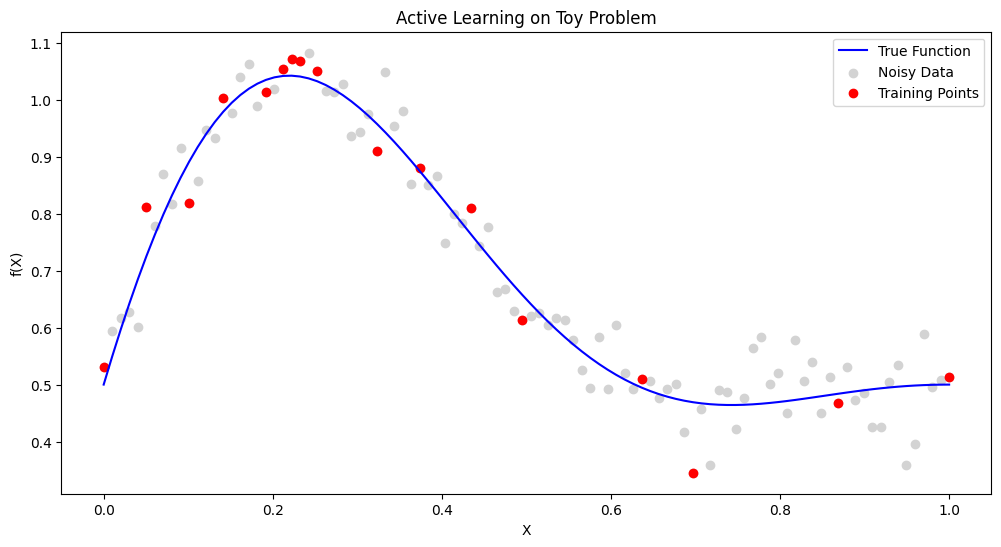

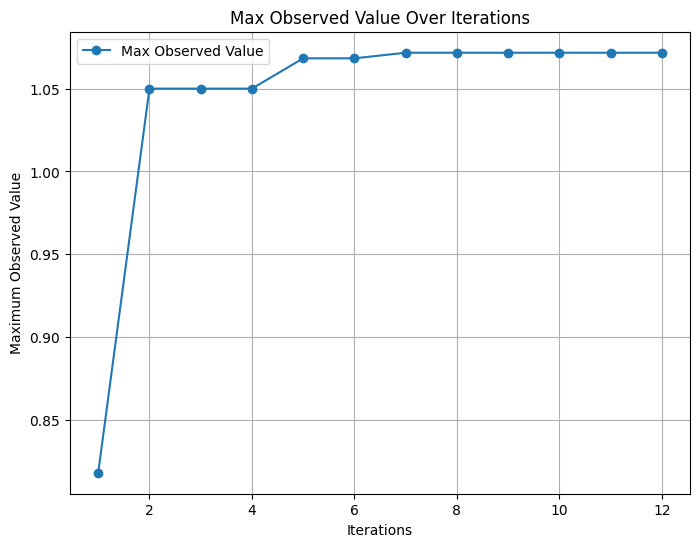

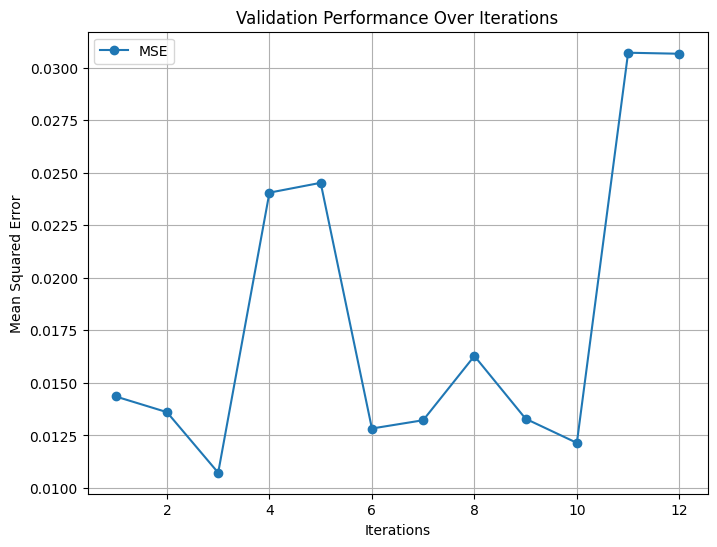

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Define the target function for the toy problem
def target_function(x):
    return np.sin(5 * x) * (1 - x) ** 2 + 0.5

# Generate toy dataset
def create_toy_data(n_samples=100, noise=0.05):
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)  # Candidates in [0, 1]
    y = target_function(X.flatten()) + np.random.normal(0, noise, size=X.shape[0])
    return X, y

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std

# Active learning loop
def run_active_learning_toy_problem(X, y, max_iterations=20, alpha_initial=3, alpha_decay=0.1, early_stopping_threshold=1e-4):
    # Normalize the data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Initial training data
    n_initial = 5  # Number of initial training points
    initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
    X_train = X[initial_indices]
    y_train = y[initial_indices]
    X_train_normalized = scaler.transform(X_train)

    # Initialize Active Learning Model
    al_model = ActiveLearningUCB(alpha=alpha_initial)
    al_model.update_model(X_train_normalized, y_train)

    # Tracking variables
    selected_indices = list(initial_indices)
    iteration_indices = []
    selected_modulus = []
    mse_per_iteration = []
    max_observed_value = []

    for iteration in range(max_iterations):
        # Dynamic alpha adjustment
        al_model.alpha = max(1, alpha_initial / (1 + iteration * alpha_decay))

        # Filter available candidates
        available_indices = [i for i in range(len(X)) if i not in selected_indices]
        X_candidates_filtered = X_normalized[available_indices]

        # Select next point
        selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
        selected_idx = available_indices[selected_idx_local]

        # Record information
        iteration_indices.append(iteration + 1)
        selected_indices.append(selected_idx)
        selected_modulus.append(y[selected_idx])
        max_observed_value.append(max(y_train))  # Track max observed modulus

        # Update training set
        X_new = X[[selected_idx]]
        y_new = y[[selected_idx]]
        X_new_normalized = scaler.transform(X_new)

        X_train = np.vstack([X_train, X_new])
        y_train = np.append(y_train, y_new)
        X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

        al_model.update_model(X_train_normalized, y_train)

        # Calculate MSE
        predictions = al_model.model.predict(X_normalized)
        mse = mean_squared_error(y, predictions)
        mse_per_iteration.append(mse)

        # Early stopping
        if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
            print(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
            break

    # Final visualization
    plot_toy_problem_results(X, y, X_train, y_train, mean, std, iteration_indices, selected_modulus, mse_per_iteration, max_observed_value)

# Visualization
def plot_toy_problem_results(X, y, X_train, y_train, mean, std, iteration_indices, selected_modulus, mse_per_iteration, max_observed_value):
    # Ground truth function
    plt.figure(figsize=(12, 6))
    plt.plot(X, target_function(X.flatten()), label="True Function", color="blue")
    plt.scatter(X, y, label="Noisy Data", color="lightgray")
    plt.scatter(X_train, y_train, label="Training Points", color="red")
    #plt.fill_between(X.flatten(), mean - 1.96 * std, mean + 1.96 * std, alpha=0.3, label="GP Confidence Interval")
    plt.xlabel("X")
    plt.ylabel("f(X)")
    plt.legend()
    plt.title("Active Learning on Toy Problem")
    plt.show()

    # Modulus vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(iteration_indices, max_observed_value, marker="o", label="Max Observed Value")
    plt.xlabel("Iterations")
    plt.ylabel("Maximum Observed Value")
    plt.title("Max Observed Value Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    # MSE vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker="o", label="MSE")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Validation Performance Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

# Run the toy problem
X, y = create_toy_data()
run_active_learning_toy_problem(X, y)


# LLM - Cohere Reranking